# Bench Press Predictor
The goal of this project is to predict how much an individual could bench press (1 rep max) based on their sex, weight class, squat max, and many other features.

## Dataset
This dataset is a snapshot of the OpenPowerlifting database as of April 2019. OpenPowerlifting is creating a public-domain archive of powerlifting history. Powerlifting is a sport in which competitors compete to lift the most weight for their class in three separate barbell lifts: the Squat, Bench, and Deadlift.

## Content
The data is represented by openpowerlifting.csv, which includes all information on the meets (competitions) as well as the competitors who attended those meets.

### Column Definitions
**Events** -> The lifts competed in. Squat, Bench, Deadlift (SBD) is the standard three powerlifts, but competitors may do only some of the lifts.

**Equipment** - The type of equipment that was worn. Federations may break competition down by different equipment.

**AgeClass** - The age class in which the lifter competed. Federations may break competition down by different age groups.

**x1Kg, x2Kg, x3Kg, x4Kg** - The first, second, and third attempts of the lift (x represents either one of SBD) in a single competition. Negative attempts means the attempt was failed.

**TotalKg** - The sum of Best3SquatKg, Best3BenchKg, Best3DeadliftKg.

**Wilks** - WIlks points, often used as a Best Lifter formula. [ [Click for more info]](https://en.wikipedia.org/wiki/Wilks_Coefficient)

**McCulloch** - McCulloch points, another formula often used as a Best Lifter formula.

**Glossbrenner** - Glossbrenner points, another formula often used as a Best Lifter formula.

**IPFPoints** - IPFPoints, a formula used as a Best Lifter formula for the IPF and its affiliates. 

In [1]:
"""Importing the Data Science Libraries"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import sklearn
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import pickle

%matplotlib inline

In [2]:
# Setting plot style 
sns.set_theme(context='poster', style='darkgrid', palette='Spectral', rc={'figure.figsize': (18, 8)})

In [3]:
X_train = pd.read_csv('data/training_data/X_train.csv')
X_test = pd.read_csv('data/testing_data/X_test.csv')
y_train = pd.read_csv('data/training_data/y_train.csv')
y_test = pd.read_csv('data/testing_data/y_test.csv')

In [4]:
X_train_shrinked = X_train.iloc[:8000, :]
y_train_shrinked = y_train.iloc[:8000]
X_test_shrinked = X_test.iloc[8000:10000, :]
y_test_shrinked = y_test.iloc[8000:10000]

In [5]:
X_train_shrinked.to_csv('data/training_data/shrinked_X_train.csv', index=False)
X_test_shrinked.to_csv("data/testing_data/shrinked_X_test.csv", index=False)
y_train_shrinked.to_csv('data/training_data/shrinked_y_train.csv', index=False)
y_test_shrinked.to_csv('data/testing_data/shrinked_y_test.csv', index=False)

In [6]:
X_train = X_train_shrinked
X_test = X_test_shrinked
y_train = y_train_shrinked
y_test = y_test_shrinked

In [7]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (8000, 17)
y_train:  (8000, 1)
X_test:  (2000, 17)
y_test:  (2000, 1)


In [8]:
# Converting label columns into pandas series 
y_train = y_train['BP']
y_test = y_test['BP']

In [9]:
print("y_train type: ", type(y_train))
print("y_test type: ", type(y_test))

y_train type:  <class 'pandas.core.series.Series'>
y_test type:  <class 'pandas.core.series.Series'>


# Data 
## The following Transformations have been applied to the data 
1) 4 numerical features (highest correlation); 13 categorical features (based on trial and error)
2) Name and Country columns have been dropped (Country = too many missing values; name = irrelevant) 
3) Missing values for numerical data have been replaced by the median
4) Missing values for categorical data have been replaced by the mode
5) All nominal variables were frequency encoded
6) WeightClassKg (ordinal variable) was label encoded
7) all columns (including categorical) were standardized using standard scaler (mean = 0, std = 1) 

# Modelling

In [10]:
# Linear Regression 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train.values, y_train)

LinearRegression()

In [11]:
# Predicting bench press values given the model trained from the training data
y_pred = lin_reg.predict(X_test)

In [12]:
# compare the errors to guage accuracy
# for linear regression, we will use square root of the mean squared error (RMSE)
# lower the rmse, the more accurate the model 
from sklearn.metrics import mean_squared_error

mse_lin = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_lin)
print(f"Linear Regression RMSE: {mse_lin}")

# The rmse score is atrocious! This highlights that our data doesn't have a linear shape

Linear Regression RMSE: 315911365798058.0


In [13]:
# lets try a decision tree classifier
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)

In [14]:
tree_mse = mean_squared_error(y_test, y_pred)

In [15]:
tree_rmse = np.sqrt(tree_mse)
print(f"Decision Tree RMSE: {tree_rmse}")

# interesting! The tree mse score is much lower than linear regression mse score

Decision Tree RMSE: 188.47745045057775


In [16]:
# cross validation (hides testing data and discourages overfitting)
from sklearn.model_selection import cross_val_score 

scores = cross_val_score(tree_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [17]:
# WHY IS THE SCORES IN CROSSVAL LOWER THAN SCORE ON TESTING SET
scores

array([-505.99599638, -421.44681388, -394.47407512, -406.949228  ,
       -348.24899763, -379.32965588, -377.95978938, -388.26692875,
       -358.89961963, -453.48630312])

In [18]:
scores = -scores
tree_rmse_crossval = np.sqrt(scores.mean())
print(f'Decision Tree RMSE (CrossVal): {tree_rmse_crossval}')

# Decision Tree Model is performing unsually well on the training set

Decision Tree RMSE (CrossVal): 20.087452321660905


In [19]:
lin_scores = -cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
lin_rmse_crossval = np.sqrt(lin_scores.mean())
lin_rmse_crossval

# crossval scores are significantly lower than testing data scores. This might be a problem 

20.945511780211163

In [20]:
# random forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train.values, y_train)
y_pred = forest_reg.predict(X_test)

In [21]:
# Cross validation for forest_Reg
def run_cross_val(model, X_train, y_train):
    """Runs cross validation on the given model and dataset"""
    scores = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
    return scores, scores.mean()

In [22]:
forest_cross_val = run_cross_val(forest_reg, X_train.values, y_train.values)

In [23]:
forest_cross_val

(array([17.48932991, 14.51493042, 14.89416335, 13.58632445, 14.94932332,
        14.48626098, 14.23744306, 13.4893    , 14.2943908 , 15.28816179]),
 14.722962808841832)

In [24]:
from sklearn.svm import SVR

svm = SVR(kernel='linear')
svm.fit(X_train.values, y_train.values)
svm_cross_val = run_cross_val(svm, X_train.values, y_train.values)

# until now, random forest regressor has performed the best! 

In [25]:
svm_cross_val

(array([23.06433827, 21.52450573, 21.18116224, 21.19036646, 22.0955179 ,
        21.25177187, 19.89240017, 19.03930108, 21.08438009, 20.70654579]),
 21.103028961163652)

In [26]:
# fine tuning hyper parameter optimization 

# Grid SearchCV
- will test out parameters from param_grid by running cross validation on the training dataset

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 25], 'max_features': [2, 4, 6, 8]},
    {'n_estimators': [3, 10], "bootstrap": [False], 'max_features': [3, 2, 5, 7]}
]

forest_reg = RandomForestRegressor() 

grid_search = GridSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', return_train_score=True, cv=10)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 25]},
                         {'bootstrap': [False], 'max_features': [3, 2, 5, 7],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
best_params_forest = grid_search.best_params_

In [29]:
best_params_forest

{'max_features': 8, 'n_estimators': 25}

In [30]:
cv_scores = grid_search.cv_results_

In [31]:
for score, param in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(np.sqrt(-score), param)

21.222857330240014 {'max_features': 2, 'n_estimators': 3}
18.523580118632236 {'max_features': 2, 'n_estimators': 10}
17.711377342493385 {'max_features': 2, 'n_estimators': 25}
19.784090362885163 {'max_features': 4, 'n_estimators': 3}
17.18822235346416 {'max_features': 4, 'n_estimators': 10}
16.434786295844386 {'max_features': 4, 'n_estimators': 25}
18.733829885916133 {'max_features': 6, 'n_estimators': 3}
16.553992480660067 {'max_features': 6, 'n_estimators': 10}
15.9121962478069 {'max_features': 6, 'n_estimators': 25}
18.548436897006233 {'max_features': 8, 'n_estimators': 3}
16.245697729387462 {'max_features': 8, 'n_estimators': 10}
15.4860338377068 {'max_features': 8, 'n_estimators': 25}
19.605959368164147 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
17.024513084230016 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
20.724677484343488 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
18.004758970719564 {'bootstrap': False, 'max_features': 2, 'n_esti

### Best Scores + Params (ATM) 
- Best Score: 15.57 (RMSE)
- Params (max_features: 8, n_estimators: 25)


In [32]:
# Let's run cross val CV again but with a modified estimator
def gridCrossValForest(param_grid, X, y):
    
    forest_reg = RandomForestRegressor() 
    grid_search = GridSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', return_train_score=True, cv=10)
    grid_search.fit(X, y)
    
    # Best paramater combination
    cv_scores = grid_search.cv_results_
    
    for score, param in zip(cv_scores['mean_test_score'], cv_scores["params"]):
        print(np.sqrt(-score), param)
    
    return grid_search, grid_search.best_params_

In [33]:
param_grid = [
    {'n_estimators': [30, 35, 40], 'max_features': [2, 8]},
]

gridCrossValForest(param_grid, X_train.values, y_train.values)

17.76054382038925 {'max_features': 2, 'n_estimators': 30}
17.614018472914367 {'max_features': 2, 'n_estimators': 35}
17.550137299753796 {'max_features': 2, 'n_estimators': 40}
15.523858617158552 {'max_features': 8, 'n_estimators': 30}
15.417232484694601 {'max_features': 8, 'n_estimators': 35}
15.38963662500703 {'max_features': 8, 'n_estimators': 40}


(GridSearchCV(cv=10, estimator=RandomForestRegressor(),
              param_grid=[{'max_features': [2, 8],
                           'n_estimators': [30, 35, 40]}],
              return_train_score=True, scoring='neg_mean_squared_error'),
 {'max_features': 8, 'n_estimators': 40})

# Observation 
- Increaing the n_estimator param lowers our MSE score.
- Incresing the max_features param also lowers the MSE score. 

# Best Score (ATM 2) 
- Best Score = 15.2
- Best Params = (max_features = 8, n_estimators = 40)

In [34]:
# GridSearchCV number 3
param_grid = [
    {'n_estimators': [100], 'max_features': [8, 12]},
]

gridCrossValForest(param_grid, X_train.values, y_train.values)

15.167761476596432 {'max_features': 8, 'n_estimators': 100}
14.943565103082454 {'max_features': 12, 'n_estimators': 100}


(GridSearchCV(cv=10, estimator=RandomForestRegressor(),
              param_grid=[{'max_features': [8, 12], 'n_estimators': [100]}],
              return_train_score=True, scoring='neg_mean_squared_error'),
 {'max_features': 12, 'n_estimators': 100})

# Feature Importance 

In [35]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importance_list = list(zip(X_train.columns, feature_importances))

In [36]:
feature_importance_list.sort(key = lambda x: x[1], reverse=True)

In [37]:
feature_importance_list

[('Best3DeadliftKg', 0.24775236735419146),
 ('Best3SquatKg', 0.23484503650681965),
 ('IPFPoints', 0.18956227623199004),
 ('BodyweightKg', 0.09884800528726095),
 ('WeightClassKg', 0.07490422756394186),
 ('Sex', 0.032390380254640104),
 ('Event', 0.02344759810770668),
 ('Equipment', 0.020659013134063126),
 ('MeetName', 0.01611550395888999),
 ('Federation', 0.014413339952936201),
 ('Place', 0.01392441984338142),
 ('Date', 0.008819767616754305),
 ('Division', 0.007841518588757649),
 ('MeetState', 0.007248251644918469),
 ('AgeClass', 0.0048504171837996345),
 ('MeetCountry', 0.004377876769948632),
 ('Tested', 0.0)]

In [38]:
X_train.drop(['Tested', 'MeetCountry', 'AgeClass', 'Division'], axis=1, inplace=True)

In [39]:
X_test.drop(['Tested', 'MeetCountry', 'AgeClass', 'Division'], axis=1, inplace=True)

In [40]:
# running our model_again
param_grid = [
    {'n_estimators': [100], 'max_features': [8, 12]},
]

grid_search, best_params = gridCrossValForest(param_grid, X_train.values, y_train.values)

14.832323095080092 {'max_features': 8, 'n_estimators': 100}
14.705271847110902 {'max_features': 12, 'n_estimators': 100}


# Best Scores + Params
- Best Score = 14.53
- Params = max_features - 12 and n_estimators - 100

In [41]:
def checkFeatureImportance(grid_search, X):
    feature_importances = grid_search.best_estimator_.feature_importances_
    feature_importance_list = list(zip(X.columns, feature_importances))
    return feature_importance_list

In [42]:
checkFeatureImportance(grid_search, X_train)

[('Best3SquatKg', 0.2166158173463773),
 ('Best3DeadliftKg', 0.3338817342272649),
 ('BodyweightKg', 0.08802938511582353),
 ('IPFPoints', 0.1829118867034001),
 ('Sex', 0.022091288465780453),
 ('Event', 0.02166874020863271),
 ('Equipment', 0.027108035269908036),
 ('WeightClassKg', 0.05380038113304477),
 ('Place', 0.01461706650304509),
 ('Federation', 0.009456564411517732),
 ('Date', 0.007446514187919994),
 ('MeetState', 0.006772684660906274),
 ('MeetName', 0.01559990176637918)]

In [43]:
# Dropping more columns 
X_train.drop(['MeetName', 'MeetState', 'Date', 'Federation', 'Place'], axis=1, inplace=True)
X_test.drop(['MeetName', 'MeetState', 'Date', 'Federation', 'Place'], axis=1, inplace=True)

In [44]:
X_train.shape

(8000, 8)

In [45]:
param_grid = [
    {'n_estimators': [200], 'max_features': [8]},
]

grid_search, best_params = gridCrossValForest(param_grid, X_train.values, y_train.values)
best_params

14.04744533721347 {'max_features': 8, 'n_estimators': 200}


{'max_features': 8, 'n_estimators': 200}

In [46]:
X_train.columns

Index(['Best3SquatKg', 'Best3DeadliftKg', 'BodyweightKg', 'IPFPoints', 'Sex',
       'Event', 'Equipment', 'WeightClassKg'],
      dtype='object')

In [47]:
X_train['Sex'].value_counts()

 0.325565    7208
-3.071580     792
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

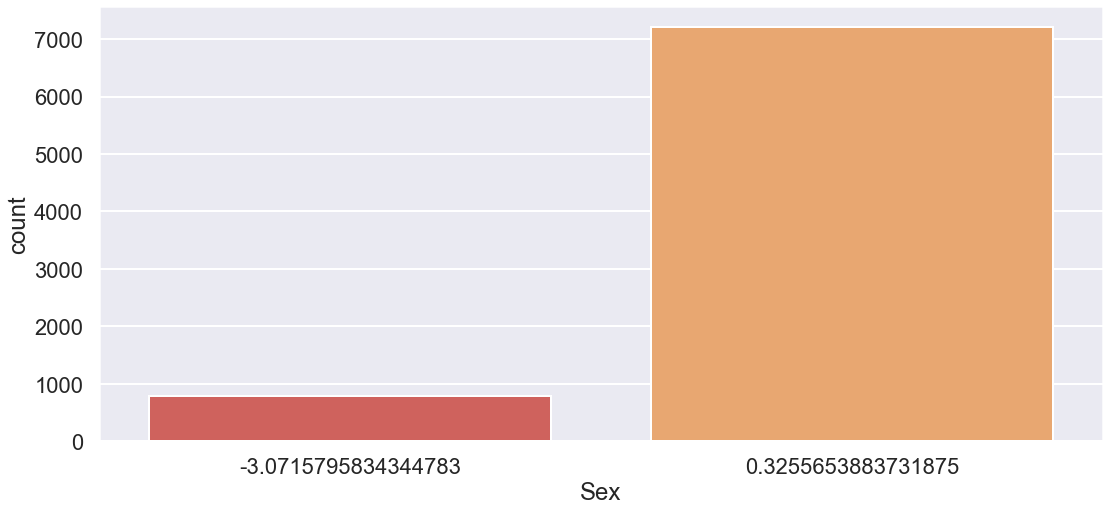

In [48]:
sns.countplot(x='Sex', data=X_train)

In [49]:
X_train['Sex'] = X_train.loc[:, 'Sex'].round(2)

In [50]:
# Setting males to 0 
# X_train.loc[X_train['Sex'] == 0.33, 'Sex'] = 0

# Setting females to 1
X_train.loc[X_train['Sex'] == -3.07, 'Sex'] = 1

In [51]:
X_train['Sex'] = X_train['Sex'].astype(int)

In [52]:
X_train['Sex'].value_counts()

0    7208
1     792
Name: Sex, dtype: int64

In [53]:
# look at the sample of 10000 that you took
# explore the sample statistical attributes, see if the central stats match or not! 
# make sure sample is representitive of the entire dataset
# cross validation is better

# different metrics are for different situations 
# each metric has different 
# explore the different error metrics (what the accuracy means)






# What to do next
- look at model
- where is it predicting values about right? 
- where is it predicting values that are wrong? 
- i.e underestimating for certain age groups. 
- i.e is there something wrong with age groups! 


Steps (After hypothesis)
1. preprocessing 
2. removing/adding new data
3. is random forest best, or is there something else that's better (XGBoost)

- Bagging improves training time for random forest
- nn.learners and maybe SGDRegressor
- tableau (no coding visualization) 
- there could be problems with the sample. take a sample of the dataset (numpy or sklearn)
- characteristics 


### EDA Phase 
- a lot of mistakes are found in the eda phase 
- are there common groups that you can make 
- can you derive any correlations 